In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import loompy as lp
import numpy as np
import pandas as pd
import scanpy as sc,anndata as ad
from pandas import Series,DataFrame
from scipy.sparse import hstack,vstack,csc_matrix
from scipy import sparse
import re
from matplotlib.backends.backend_pdf import PdfPages
#import leidenalg
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rpy2
import rpy2.rinterface
import gseapy as gp
from rpy2.robjects import globalenv   
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from gseapy.plot import barplot, dotplot
pandas2ri.activate()

In [2]:
main_path='D:\\CCLE'
save_data='D:\\CCLE\\data\\'
save_pic='D:\\CCLE\\pic\\'

In [3]:
#file reading
#Gene expression
CCLE_TPM = pd.read_csv(main_path+'/raw/CCLE_expression.csv')
CCLE_TPM.index=CCLE_TPM['Unnamed: 0']
CCLE_TPM=CCLE_TPM.drop(columns='Unnamed: 0') 
CCLE_TPM.columns=[re.search(r"\S+",i).group() for i in CCLE_TPM.columns]
CCLE_TPM=CCLE_TPM.T
#data phenotype
CCLE_pheno = pd.read_csv(main_path+'/raw/sample_info.csv')
CCLE_pheno.index=CCLE_pheno['DepMap_ID']
#Mutation
CCLE_maf=pd.read_csv(main_path+'/raw/CCLE_mutations.csv') 
CCLE_maf['Tumor_Seq_Allele2']=CCLE_maf['Alternate_Allele']
CCLE_maf['Tumor_Sample_Barcode']=CCLE_maf['DepMap_ID']
#Metabolomics
CCLE_Metabolomics=pd.read_csv(main_path+'/raw/Metabolomics.csv') 
CCLE_Metabolomics.index=CCLE_Metabolomics['Unnamed: 0']
CCLE_Metabolomics=CCLE_Metabolomics.drop(columns='Unnamed: 0') 
#Protein expression
CCLE_pro = pd.read_csv(main_path+'/raw/Proteomics.csv')
CCLE_pro.index=CCLE_pro['Unnamed: 0']
CCLE_pro=CCLE_pro.drop(columns='Unnamed: 0') 
CCLE_pro.columns=[re.search(r"\S+",i).group() for i in CCLE_pro.columns]
CCLE_pro=CCLE_pro.T
#CRISPR data
CCLE_CRISPR=pd.read_csv(main_path+'/raw/CRISPR_(DepMap_22Q2_Public+Score,_Chronos).csv') 
CCLE_CRISPR.index=CCLE_CRISPR['Unnamed: 0']
CCLE_CRISPR=CCLE_CRISPR.drop(columns='Unnamed: 0') 
CCLE_CRISPR=CCLE_CRISPR.T
#Metmap
CCLE_metmap500MP=pd.read_csv(main_path+'/raw/MetMap_500__Metastatic_Potential.csv') 
CCLE_metmap500MP.index=CCLE_metmap500MP['Unnamed: 0']
CCLE_metmap500MP=CCLE_metmap500MP.drop(columns='Unnamed: 0') 
#drug sensitivity
CCLE_drug=pd.read_csv(main_path+'/raw/Drug_sensitivity_(PRISM_Repurposing_Primary_Screen)_19Q4.csv') 
CCLE_drug.index=CCLE_drug['Unnamed: 0']
CCLE_drug=CCLE_drug.drop(columns='Unnamed: 0') 
CCLE_drug.columns=[re.search(r"\S+",i).group() for i in CCLE_drug.columns]


C:\Users\liuxf\AppData\Local\Temp\ipykernel_11496\4041328432.py:12: DtypeWarning: Columns (3,19,22,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  CCLE_maf=pd.read_csv(main_path+'/raw/CCLE_mutations.csv')


In [4]:
CCLE_pheno_lung=CCLE_pheno.loc[(CCLE_pheno['primary_disease']=='Lung Cancer') ,:]
CCLE_metmap500MP_lung=CCLE_metmap500MP.loc[list(set(CCLE_pheno_lung.index).intersection(set(CCLE_metmap500MP.index))),:]
CCLE_metmap500MP_lung['CCLE_name']=list(CCLE_metmap500MP_lung.index)
CCLE_metmap500MP_lung['Celllinename']=list(CCLE_pheno.loc[CCLE_metmap500MP_lung.index,'cell_line_name'])

for i in CCLE_metmap500MP_lung.columns[0:6]:
    CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung[i]< -4, i+'_color']='Non-metastatic'
    CCLE_metmap500MP_lung.loc[(CCLE_metmap500MP_lung[i]> -4) & (CCLE_metmap500MP_lung[i]< -2),i+'_color']='Weakly metastatic'
    CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung[i]> -2 ,i+'_color']='Metastatic'
CCLE_metmap500MP_lung = CCLE_metmap500MP_lung.sort_values(by=['all5'],ascending=False )

C:\Users\liuxf\AppData\Local\Temp\ipykernel_11496\1970180087.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'tmp1.pdf',dpi=400,facecolor='white',overwrite=True)


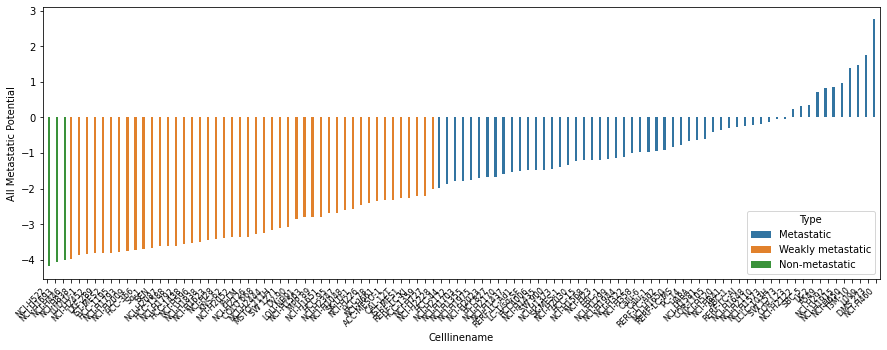

In [5]:
fig = plt.figure(figsize=(15, 5)) 
ax = fig.add_subplot(111)
bars =sns.barplot(x= 'Celllinename', y='all5',hue='all5_color',data=CCLE_metmap500MP_lung,order=CCLE_metmap500MP_lung.sort_values(by='all5')['Celllinename'] )
x_axis = bars.axes.get_xaxis()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45,fontsize=8)
ax.legend(title='Type')
plt.ylabel("All Metastatic Potential")
plt.savefig(save_pic+'tmp1.pdf',dpi=400,facecolor='white',overwrite=True)

C:\Users\liuxf\AppData\Local\Temp\ipykernel_11496\2335093300.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'tmp2.pdf',dpi=400,facecolor='white',overwrite=True)


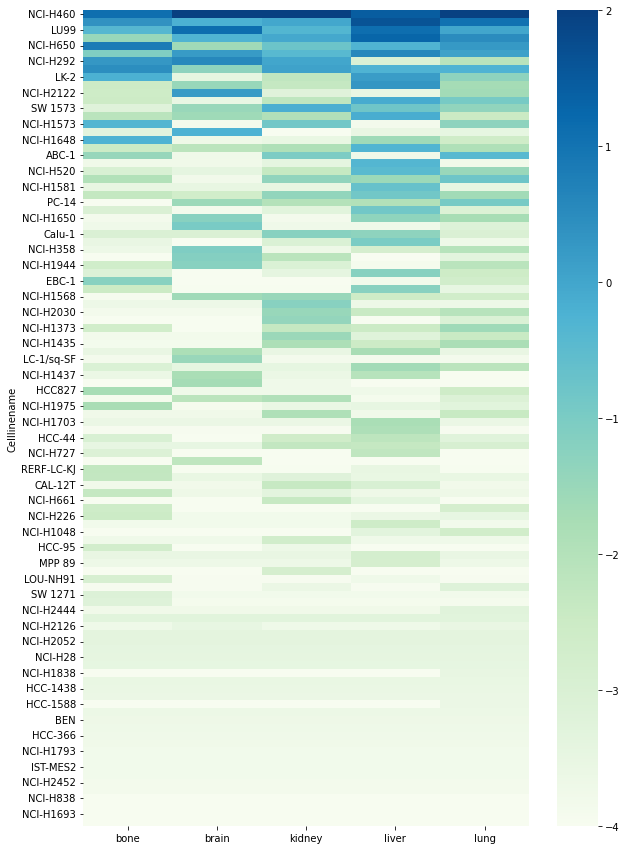

In [6]:
tmp_pic=CCLE_metmap500MP_lung
tmp_pic.index=tmp_pic['Celllinename']
fig = plt.figure(figsize=(10, 15)) 
sns.heatmap(tmp_pic.loc[:,['bone','brain','kidney','liver','lung']] , vmin=-4, vmax=2 , cmap="GnBu")
plt.savefig(save_pic+'tmp2.pdf',dpi=400,facecolor='white',overwrite=True)

C:\Users\liuxf\AppData\Local\Temp\ipykernel_11496\707724287.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'tmp3.pdf',dpi=400,facecolor='white',overwrite=True)


<Figure size 720x1080 with 0 Axes>

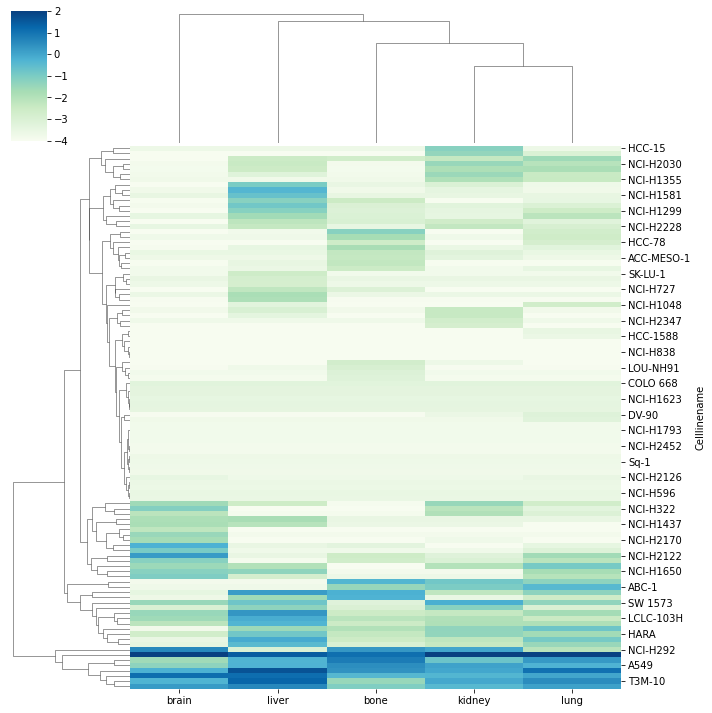

In [7]:
fig = plt.figure(figsize=(10, 15)) 
g = sns.clustermap(tmp_pic.loc[:,['bone','brain','kidney','liver','lung']] , vmin=-4, vmax=2 , cmap="GnBu")
plt.savefig(save_pic+'tmp3.pdf',dpi=400,facecolor='white',overwrite=True)

In [8]:
CCLE_metmap500MP_lung['Group']='Metastatic'
CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung['all5_color'] != 'Metastatic','Group']='Non_Metastatic'
CCLE_metmap500MP_lung.index=CCLE_metmap500MP_lung['CCLE_name']
intersect_sample=list( set(CCLE_metmap500MP_lung['CCLE_name']).intersection(set(CCLE_TPM.columns)) )
CCLE_metmap500MP_lung=CCLE_metmap500MP_lung.loc[intersect_sample,:]
CCLE_TPM_lung=CCLE_TPM.loc[:,intersect_sample]


design=pd.DataFrame({'Metastatic': [int(x) for x in list((CCLE_metmap500MP_lung['Group']=='Metastatic'))] ,"Non_Metastatic":[int(x) for x in list((CCLE_metmap500MP_lung['Group']=='Non_Metastatic'))]},index=list(CCLE_metmap500MP_lung['Group']))
limma=importr("limma")
rdf1=pandas2ri.py2rpy(CCLE_TPM_lung)
rdf2=pandas2ri.py2rpy(design)
globalenv['rdf1']=rdf1
globalenv['rdf2']=rdf2
rscript='''
contrasts_matrix<-makeContrasts("Metastatic-Non_Metastatic",levels=rdf2)
fit<-lmFit(rdf1,rdf2)
fit2<-contrasts.fit(fit,contrasts_matrix)
fit2<-eBayes(fit2)
temp<-topTable(fit2,coef=1,n=Inf)
nrDEG=na.omit(temp)
'''
Degs_lung=r(rscript)
Degs_lung['Group']='No.sig'
Degs_lung.loc[(Degs_lung['logFC']>0.58) & (Degs_lung['P.Value']<0.05),'Group']='Metastatic'
Degs_lung.loc[(Degs_lung['logFC']< -0.58) & (Degs_lung['P.Value']<0.05),'Group']='Non-Metastatic'
Degs_lung['P.Val_log']=-np.log10(Degs_lung['P.Value']) 

C:\Users\liuxf\AppData\Local\Temp\ipykernel_11496\2693469027.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'tmp4.pdf',dpi=400,facecolor='white',overwrite=True)


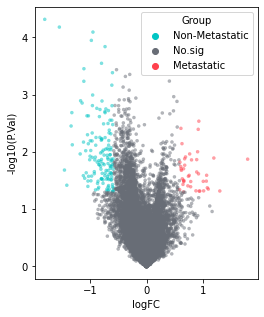

In [9]:
fig = plt.figure(figsize=(4, 5)) 
colors=["#01c5c4","#686d76","#ff414d"]
sns.set_palette(sns.color_palette(colors))
ax=sns.scatterplot(x='logFC',y='P.Val_log',data=Degs_lung,hue='Group',edgecolor=None,s=10,alpha=0.5)
ax.set_xlabel("logFC")
ax.set_ylabel("-log10(P.Val)")
plt.savefig(save_pic+'tmp4.pdf',dpi=400,facecolor='white',overwrite=True)


d:\Users\liuxf\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\liuxf\AppData\Local\Temp\ipykernel_11496\1701627911.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'tmp5.pdf',dpi=400,facecolor='white',overwrite=True)


<Figure size 288x1440 with 0 Axes>

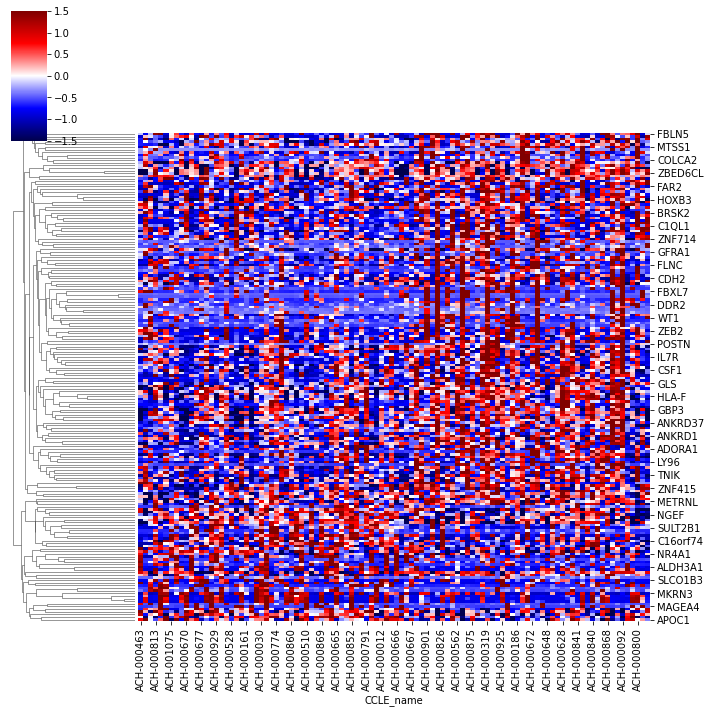

In [10]:
CCLE_metmap500MP_lung = CCLE_metmap500MP_lung.sort_values(by=['all5'],ascending=False )
sig_gene=list(Degs_lung.loc[Degs_lung['Group']!='No.sig',:].index)
fig = plt.figure(figsize=(4, 20)) 
sns.clustermap(CCLE_TPM_lung.loc[sig_gene,CCLE_metmap500MP_lung.index],cmap='seismic', z_score=0, vmin=-1.5, vmax=1.5,col_cluster=False)
plt.savefig(save_pic+'tmp5.pdf',dpi=400,facecolor='white',overwrite=True)

In [26]:
gene_sets='KEGG_2016'
enr_up = gp.enrichr(gene_list=list(Degs_lung.loc[Degs_lung['Group']=='Metastatic',:].index),
                 gene_sets=gene_sets,organism='human',
                 outdir=save_pic+'/up',cutoff=0.5 )
enr_down = gp.enrichr(gene_list=list(Degs_lung.loc[Degs_lung['Group']=='Non-Metastatic',:].index),
                 gene_sets=gene_sets,organism='human',
                 outdir=save_pic+'/down',cutoff=0.5 )   

pre_res = gp.prerank(rnk=pd.DataFrame(Degs_lung['logFC'],index=Degs_lung.index).sort_values(by=['logFC'],ascending=False ), gene_sets='KEGG_2016',
                     processes=4,
                     outdir=save_pic+'/GSEA', format='pdf', seed=6)          

C:\Users\liuxf\AppData\Local\Temp\ipykernel_11496\3554000450.py:9: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(rnk=pd.DataFrame(Degs_lung['logFC'],index=Degs_lung.index).sort_values(by=['logFC'],ascending=False ), gene_sets='KEGG_2016',
2022-12-22 10:41:46,433 [WARNING] Duplicated values found in preranked stats: 0.79% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [29]:
TF = pd.read_table(main_path+'/data/tf-target-infomation.txt')
TF_new={}
for i in np.unique(list(TF['TF'])):
     TF_new[i]=list(TF.loc[TF['TF']==i,'target'])
pre_TF = gp.prerank(rnk=pd.DataFrame(Degs_lung['logFC'],index=Degs_lung.index).sort_values(by=['logFC'],ascending=False ), gene_sets=TF_new,
                     processes=4,
                     outdir=save_pic+'/TF', format='pdf', seed=6) 
ssgsea =gp.ssgsea(data=CCLE_TPM_lung, gene_sets='KEGG_2016', outdir=save_pic+'/ssGSEA')                        

In [43]:
ssgsea_lung=pd.read_csv(save_pic+'/ssGSEA/gseapy.gene_set.ssgsea.report.csv')
tf_lung=pd.read_csv(save_pic+'/TF/gseapy.gene_set.prerank.report.csv')
tf_lung=tf_lung


In [11]:
#---转移组与非转移组药物敏感性比较------

intersect_sample=list( set(CCLE_metmap500MP_lung['CCLE_name']).intersection(set(CCLE_drug.index)) )
CCLE_metmap500MP_lung_drug=CCLE_metmap500MP_lung.loc[intersect_sample,:]
CCLE_drug_lung=CCLE_drug.loc[intersect_sample,:]

In [12]:
intersect_sample

['ACH-001075',
 'ACH-000774',
 'ACH-000891',
 'ACH-000482',
 'ACH-001113',
 'ACH-000015',
 'ACH-000521',
 'ACH-000496',
 'ACH-000343',
 'ACH-000787',
 'ACH-000528',
 'ACH-000893',
 'ACH-000924',
 'ACH-000670',
 'ACH-000264',
 'ACH-000414',
 'ACH-000066',
 'ACH-000553',
 'ACH-000785',
 'ACH-000292',
 'ACH-000161',
 'ACH-000319',
 'ACH-000628',
 'ACH-000176',
 'ACH-000769',
 'ACH-000900',
 'ACH-000331',
 'ACH-000030',
 'ACH-000781',
 'ACH-000153',
 'ACH-000868',
 'ACH-000840',
 'ACH-000766',
 'ACH-000447',
 'ACH-000878',
 'ACH-000186',
 'ACH-000852',
 'ACH-000929',
 'ACH-000826',
 'ACH-000569',
 'ACH-000775',
 'ACH-000311',
 'ACH-000021',
 'ACH-000860',
 'ACH-000562',
 'ACH-000589',
 'ACH-000662',
 'ACH-000916',
 'ACH-000092',
 'ACH-000869',
 'ACH-000648',
 'ACH-000510',
 'ACH-000886',
 'ACH-000858',
 'ACH-000563',
 'ACH-000890',
 'ACH-000481',
 'ACH-000866',
 'ACH-000669',
 'ACH-000892',
 'ACH-000463',
 'ACH-000587',
 'ACH-000062',
 'ACH-000803',
 'ACH-000667',
 'ACH-000841',
 'ACH-0007